## Preparing for sentiment Analysis using BERT

In [13]:
#Import packages
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

#Set working directory
cwd = os.getcwd()

In [2]:
#Import the dataframes
df_comment = pd.read_csv(cwd+"/data/Comment_dataset_processed.csv")
df_submission = pd.read_csv(cwd+"/data/Post_dataset_processed.csv")

In [8]:
#Import the tokenized and model
tokenizer = AutoTokenizer.from_pretrained("Seethal/sentiment_analysis_generic_dataset")
model = TFAutoModelForSequenceClassification.from_pretrained("Seethal/sentiment_analysis_generic_dataset", from_pt=True)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


## Preprocessing
The maximum length per comment that the model can handle is 512. However, based on the distribution of the length of the comments only 8.59% would be too long to analyze.
To optimize the performance of the model, the comments with more than 512 tokens will be removed.

Percentage of rows that exceed a length of 512 tokens: 8.59%


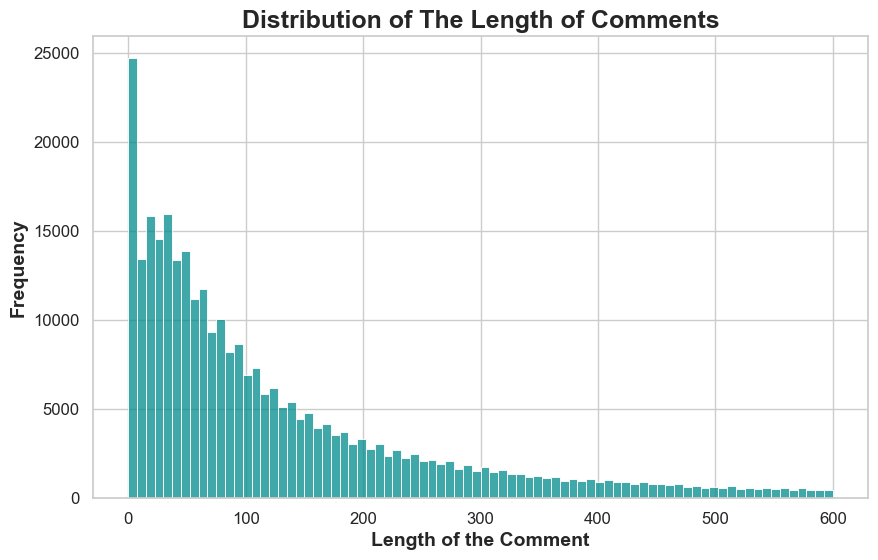

In [22]:
#Printing the percentage of rows that exceed a length of 130
print(f"Percentage of rows that exceed a length of 512 tokens: {((len(df_comment[df_comment['Comment Text'].str.len() > 512])/len(df_comment)) * 100):.2f}%")

#Plotting the histogram of the distribution of the length of the comments
color = "darkcyan"

plt.figure(figsize=(10, 6))
histogram = sns.histplot(data=df_comment['Comment Text'].str.len(), bins=80, kde=False, binrange=[0, 600], color=color)

plt.xlabel('Length of the Comment', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of The Length of Comments' , fontsize=18, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


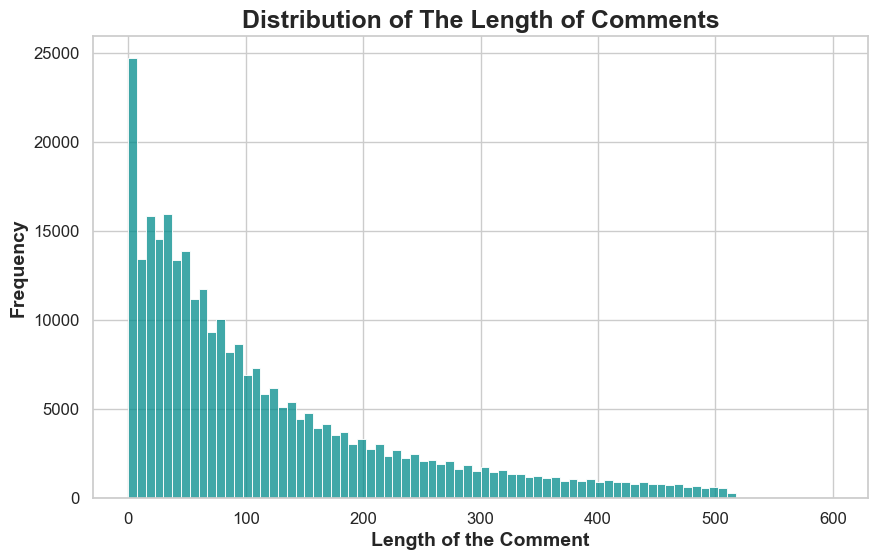

In [95]:
#removing rows with "Comment Text" Length > 512
df_comment = df_comment[df_comment['Comment Text'].str.len() <= 512]

#Plotting the histogram of the remaining comments
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
histogram = sns.histplot(data=df_comment['Comment Text'].str.len(), bins=80, kde=False, binrange=[0, 600], color="darkcyan")

plt.xlabel('Length of the Comment', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of The Length of Comments' , fontsize=18, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## Getting the sentiment score

This scaling operation maps the range of 'x' from its original range to a new range between 0 and 1. For example, when the original value of 'x' is -4, the scaled value would be 0, and if the original value of 'x' is 4, the scaled value would be 1.

In [23]:
#To explain how the sentiment works, we will use the following sentence:
length = 20000
sentence = "a" * length

#Using the tokenizer to encode the sentence and return the input as tensor
inputs = tokenizer(sentence, return_tensors="tf")
logits = model(**inputs).logits

#Getting the sentimnet
scale = lambda x: (x+4) / 8
print(f"Logits unedited: {logits[0]}")
print(f"Logits scaled 0-1: {scale(logits[0])}")
logits = [scale(logits[0])[0], scale(logits[0])[2]]
print(f"Logits softmax: {logits}") #Softmax normalizes the logits to a probability distribution
print(f"negative: {logits[0]}")
print(f"Positive: {logits[1]}")
print(f"Sentiment Score: {logits[1] - logits[0]}")

Logits unedited: [-0.7556559   0.555634    0.02431944]
Logits scaled 0-1: [0.40554303 0.56945425 0.50303996]
Logits softmax: [<tf.Tensor: shape=(), dtype=float32, numpy=0.40554303>, <tf.Tensor: shape=(), dtype=float32, numpy=0.50303996>]
negative: 0.4055430293083191
Positive: 0.5030399560928345
Sentiment Score: 0.09749692678451538


In [196]:
#Getting the sentiment score for the comments
def sentiment_score(df_file: pd.DataFrame, column_name: str, batch_size: int):
    """
    Assign a preprocessed dataframe to df_file
    Assign a single column name to column_name for the text to be used for sentiment analysis
    Assign a batch size to batch_size for processing in batches (in accordence with GPU capabilities)
    Tokenizes the text and returns the sentiment score and label for each text
    Returns the dataframe with the new columns; Sentiment, Negative, Neutral & Positive.
    """
    scale = lambda x: (x+4) / 8
    negative = np.array([])
    neutral = np.array([])
    positive = np.array([])
    n = len(df_file)
    num_batches = n // batch_size + int(n % batch_size != 0)
    for i in tqdm(range(num_batches), total=num_batches):
        start = i * batch_size
        end = min(start + batch_size, n)
        batch = df_file.iloc[start:end][column_name].values.tolist()
        try:
            tokens = tokenizer(batch, return_tensors="tf", padding=True, truncation=True)
        except:
            print("Error at", i, "around index", i * batch_size)

        inputs = {key: tuple(value.numpy().tolist()) for key, value in tokens.items()} 
        inputs = inputs["input_ids"]
        with tf.device('/gpu:0'): #in order to make use of the GPU
            predictions = model.predict(inputs, verbose=False)["logits"]
        negative = np.concatenate((negative, scale(predictions)[:,0]))
        neutral = np.concatenate((neutral, scale(predictions)[:,1]))
        positive =  np.concatenate((positive, scale(predictions)[:,2]))

    #Calculating the sentiment score
    sentiment = positive - negative
    #Adding the columns        
    df_file["Sentiment"] = sentiment
    df_file["Negative"] = negative
    df_file["Neutral"] = neutral
    df_file["Positive"] = positive
    return df_file

100%|██████████| 10119/10119 [37:10<00:00,  4.54it/s]


In [ ]:
#Calling the function
df_comment.dropna(subset=['Comment Text'], inplace=True) #Keeping only what we need for the sentiment analysis
df_sentiment_score = sentiment_score(df_file=df_comment, column_name="Comment Text", batch_size=32)
df_sentiment_score.to_csv(cwd+"/data/Comment_sentiment_score.csv", index=False)

## Exploring the results

In [4]:
#What the dataframe looks like
df_sentiment_score.head()

,Subreddit,ID of Post,Comment Text,Score,Author,Date & Time,Length Comment,Sentiment,Negative,Neutral,Positive
0,ChatGPT,12cobqr,Recognizing ASCII shrek is the last step to AGI,2180,EwaldvonKleist,2023-04-05 18:30:30,47.0,0.047255,0.235685,0.935315,0.282940
1,ChatGPT,12cobqr,"That's , green icon",644,anonymoose137,2023-04-05 18:35:14,20.0,0.050144,0.222395,0.957861,0.272538
2,ChatGPT,12cobqr,It’s not though,358,I_am_purrfect,2023-04-05 18:31:39,17.0,0.049684,0.223553,0.956854,0.273237
3,ChatGPT,12cobqr,This is not,526,vitorgrs,2023-04-05 18:38:06,13.0,0.031196,0.231278,0.957389,0.262474
4,ChatGPT,12cobqr,Can someone in the comments please do this aga...,138,Soibi0gn,2023-04-05 18:48:17,135.0,0.064101,0.261577,0.870682,0.325677


C:\Users\noort\AppData\Local\Temp\ipykernel_3364\1447913079.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sentiment_score_daily = df_sentiment_score.groupby(['Date']).mean().reset_index()


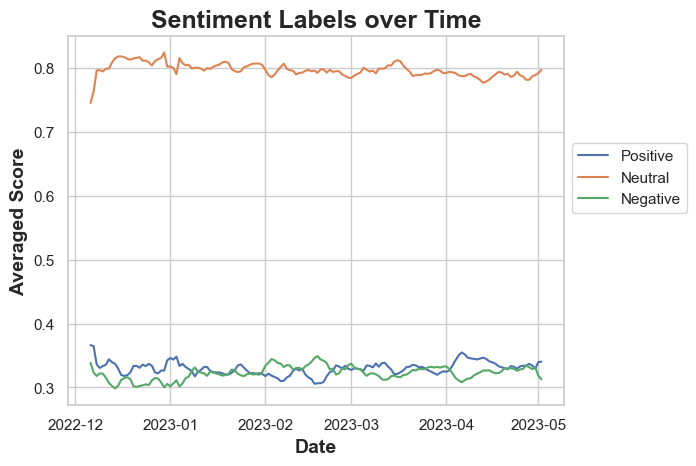

In [5]:
#Plotting the distribution of the sentiment labels over time

#Sorting the dataframe by date
df_sentiment_score.sort_values(by=["Date & Time"], inplace=True)
#Adding a column that extracts the date from the datetime column:
df_sentiment_score['Date'] = pd.to_datetime(df_sentiment_score['Date & Time']).dt.date

#Creating a new dataset with 4 columns, every row is a unique day, and the columns are the average sentiment score, negative, neutral and positive:
df_sentiment_score_daily = df_sentiment_score.groupby(['Date']).mean().reset_index()
#df_sentiment_score_daily["scaled_sentiment"] is the sentiment score for each day, scaled between 0 and 1 based on the positive and negative sentiment scores for the entire period, excluding the neutral sentiment score
df_sentiment_score_daily["scaled_sentiment"] = (df_sentiment_score_daily["Sentiment"] - df_sentiment_score_daily["Sentiment"].min()) / (df_sentiment_score_daily["Sentiment"].max() - df_sentiment_score_daily["Sentiment"].min())

sns.set(style="whitegrid")

plt.plot(df_sentiment_score_daily['Date'], df_sentiment_score_daily['Positive'].rolling(window=4).mean(), label='Positive')
plt.plot(df_sentiment_score_daily['Date'], df_sentiment_score_daily['Neutral'].rolling(window=4).mean(), label='Neutral')
plt.plot(df_sentiment_score_daily['Date'], df_sentiment_score_daily['Negative'].rolling(window=4).mean(), label='Negative')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Averaged Score', fontsize=14, fontweight='bold')
plt.title('Sentiment Labels over Time' , fontsize=18, fontweight='bold')
plt.show()


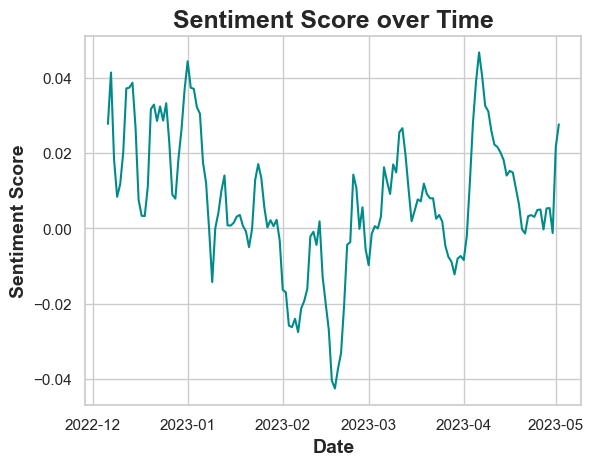

In [6]:
#Plotting the sentiment score over time
plt.plot(df_sentiment_score_daily['Date'], df_sentiment_score_daily['Sentiment'].rolling(window=4).mean(), label='Sentiment Score', color="darkcyan")

sns.set(style="whitegrid")

plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=14, fontweight='bold')
plt.title('Sentiment Score over Time' , fontsize=18, fontweight='bold')
plt.show()


In [7]:
#Statistics on the sentiment score
print(f"Some information about the sentiment score:\n{df_sentiment_score['Sentiment'].describe()}\n")


Some information about the sentiment score:
count    323793.000000
mean          0.006029
std           0.263722
min          -0.881382
25%          -0.024237
50%           0.021006
75%           0.056247
max           1.007990
Name: Sentiment, dtype: float64



In [10]:
#looking at the comment text with the highest and lowest sentiment score
print(df_sentiment_score[df_sentiment_score['Sentiment'] == df_sentiment_score['Sentiment'].max()]['Comment Text'])
#As someone who has been following the development of natural language processing (NLP) technologies for years, I must say that I am absolutely thrilled by the emergence of  .
#For those who are not familiar with it,   is a cutting-edge NLP technology that allows users to engage in natural, conversational exchanges with a machine-learning model.
#What sets   apart from other NLP technologies is its ability to generate responses that are not only accurate and coherent, but also engaging and compelling. In other words, it can not only understand what you are saying,
#but it can also respond in a way that is relevant, thoughtful, and even witty. This level of interaction is something that we have never seen before in the world of NLP, 
#and it represents a major step forward in our ability to create truly intelligent machines.
#But the potential applications of   are not limited to mere conversation. With its ability to understand and respond to complex inputs,   has the potential to revolutionize the way we interact with computers in a wide range of contexts. For example,
#it could be used to create virtual assistants that are capable of providing personalized, intelligent support to users in real-time. It could also be used to power advanced chatbots that can help users navigate complex systems and processes,
#or even provide personalized recommendations based on their interests and preferences.
#In short,   represents a major leap forward in the field of NLP, and I am incredibly excited to see how it will be used in the coming years. It has the potential to revolutionize the way we interact with computers,
#and I can't wait to see what the future holds for this incredible technology.
#[this was made in  , but pretty much sums it up]

print(df_sentiment_score[df_sentiment_score['Sentiment'] == df_sentiment_score['Sentiment'].min()]['Comment Text'])
#Why do I fucking feel 20 years from now in a post-apocalyptic landscape somewhere I am going to run into one of these surviving AI ethics team members in a cave who explains to me "We tried to warn them,
#but they just wouldn't listen." when I ask him on how the world was destroyed and the bots took over.

171410    As someone who has been following the developm...
Name: Comment Text, dtype: object
66067    Why do I fucking feel 20 years from now in a p...
Name: Comment Text, dtype: object


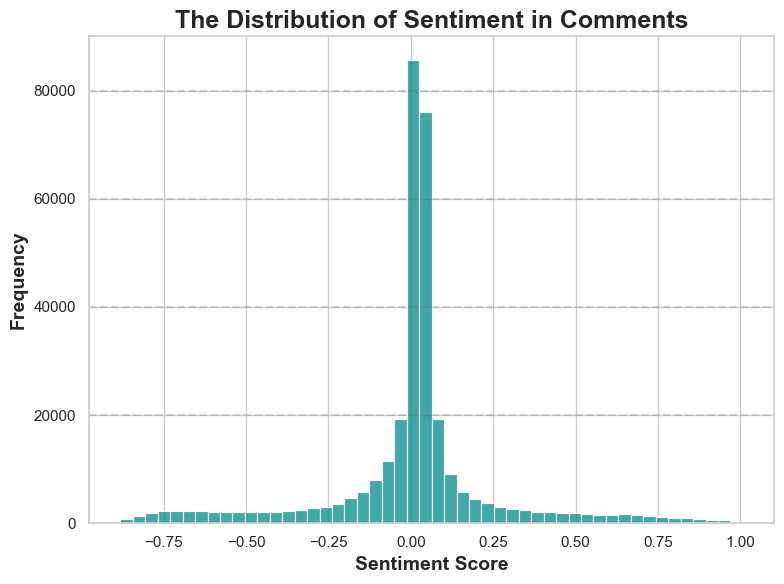

In [8]:
#Plotting the distribution of the sentiment score
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df_sentiment_score, x='Sentiment', bins=50, kde=False, ax=ax, color="darkcyan")

plt.xlabel('Sentiment Score', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('The Distribution of Sentiment in Comments' , fontsize=18, fontweight='bold')

for y in ax.get_yticks()[1:-1]:
    ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

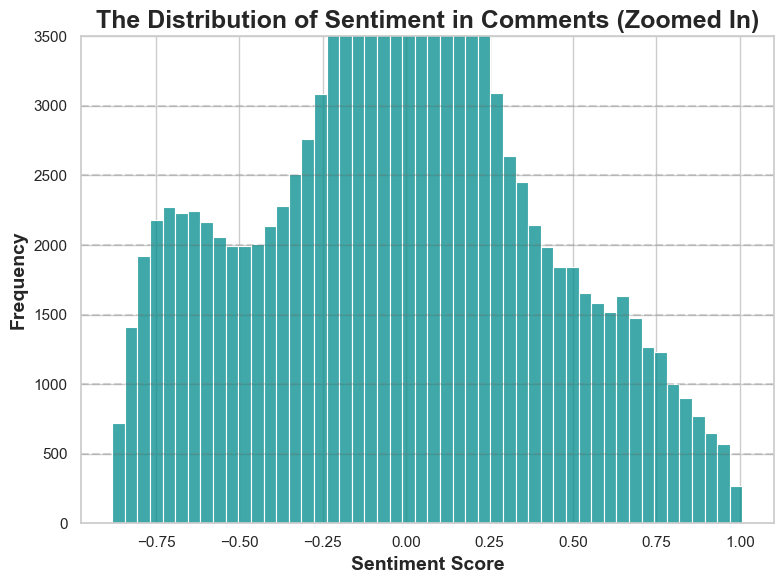

In [9]:
#Zooming the plot in to get more detailed information
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df_sentiment_score, x='Sentiment', bins=50, kde=False, ax=ax, color="darkcyan")

ax.set_xlabel('Sentiment Score', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
ax.set_title('The Distribution of Sentiment in Comments (Zoomed In)', fontsize=18, fontweight='bold')

ax.set_ylim(0, 3500) #to zoom in

for y in ax.get_yticks()[1:-1]:
    ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [63]:
#Percentage of neutral comments: sentiment score between -0.25 and 0.25
print(f"The percentage of comments with a sentiment score between -0.25 and 0.25 is: {round(len(df_sentiment_score[(df_sentiment_score['Sentiment'] >= -0.25) & (df_sentiment_score['Sentiment'] <= 0.25)])/len(df_sentiment_score)*100, 2)}%\n")
#Percentage of negative comments: sentiment score smaller than -0.25
print(f"The percentage of comments with a sentiment score smaller than -0.25 is: {round(len(df_sentiment_score[df_sentiment_score['Sentiment'] < -0.25])/len(df_sentiment_score)*100, 2)}%\n")
#Percentage of positive comments: sentiment score larger than 0.25
print(f"The percentage of comments with a sentiment score larger than 0.25 is: {round(len(df_sentiment_score[df_sentiment_score['Sentiment'] > 0.25])/len(df_sentiment_score)*100, 2)}%\n")

#Removing rows with a sentiment score between -0.25 and 0.25
df_sentiment_nonneutral = df_sentiment_score[(df_sentiment_score['Sentiment'] < -0.25) | (df_sentiment_score['Sentiment'] > 0.25)]
#Percantage of sentiment smaller than -0.5
print(f"The percentage of comments with a sentiment score smaller than -0.5 is (after removing neutral comments): {round(len(df_sentiment_nonneutral[df_sentiment_nonneutral['Sentiment'] < -0.5])/len(df_sentiment_nonneutral)*100, 2)}%\n")
#Percentage of sentiment larger than 0.5
print(f"The percentage of comments with a sentiment score larger than 0.5 is(after removing neutral comments): {round(len(df_sentiment_nonneutral[df_sentiment_nonneutral['Sentiment'] > 0.5])/len(df_sentiment_nonneutral)*100, 2)}%")

The percentage of comments with a sentiment score between -0.25 and 0.25 is: 79.69%

The percentage of comments with a sentiment score smaller than -0.25 is: 10.81%

The percentage of comments with a sentiment score larger than 0.25 is: 9.5%

The percentage of comments with a sentiment score smaller than -0.5 is (after removing neutral comments): 29.49%

The percentage of comments with a sentiment score larger than 0.5 is(after removing neutral comments): 23.34%


## Combining the sentiments results with the topics

In [103]:
df_post = pd.read_csv(cwd+ '/data/df_post.csv')
df_post_topic = pd.read_csv(cwd+ '/data/df_post_topic.csv')

In [104]:
#Adding new columns to the df_post_topic dataset
df_post_topic['ID of Post'] = 0
#Filling the new column
df_post_topic.update(df_post)

#Adding the average sentiment score per post
for id in df_post_topic['ID of Post']:
    avg_sentiment = df_sentiment_score[df_sentiment_score['ID of Post'] == id]['Sentiment'].mean()
    df_post_topic.loc[df_post_topic['ID of Post'] == id, 'Sentiment'] = avg_sentiment

#Clean up the dataset
df_post_topic.drop(['Unnamed: 0', 'Top_n_words', 'Probability', 'Representative_document'], axis=1, inplace=True)
df_post_topic.rename(columns={'Name': 'Topic Name', 'Topic':'Topic Number', 'Sentiment':'Average Sentiment'}, inplace=True)

df_post_topic.head()


,Title Post,Topic Number,Topic Name,ID of Post,Average sentiment
0,Was curious if GPT-4 could recognize text art,4,4_art_image_design_ascii,12cobqr,0.027680
1,Unfiltered ChatGPT opinion about Reddit,-1,-1_like_ai_im_chatgpt,12ed85v,-0.006945
2,I will never forgive myself for falling for this…,13,13_love_vou_children_make,12b7bos,0.052039
3,"10/10, must-see moment! ChatGPT just did somet...",0,0_chatgpt_plugins_does_able,zj2aeu,0.054172
4,wow it is so smart 💀,3,3_chatgpt_install_app_api,11yau45,-0.033391


In [105]:
#Basic statistics on the average sentiment score per post
print(f"Some information about the average sentiment score per post:\n{df_post_topic['Average sentiment'].describe()}\n")

Some information about the average sentiment score per post:
count    1067.000000
mean        0.009824
std         0.058587
min        -0.151273
25%        -0.028785
50%         0.006429
75%         0.042535
max         0.376713
Name: Average sentiment, dtype: float64



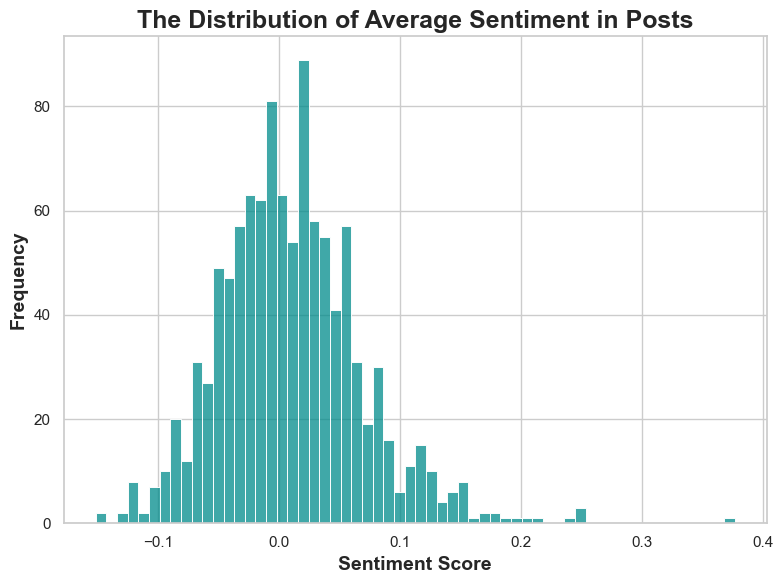

In [112]:
#Plotting the distribution of the sentiment score in posts
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df_post_topic, x='Average sentiment', bins=60, kde=False, ax=ax, color="darkcyan")

plt.xlabel('Sentiment Score', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('The Distribution of Average Sentiment in Posts' , fontsize=18, fontweight='bold')

plt.tight_layout()
plt.show()

In [120]:
#Grouping the sentiment score by topic
df_topic_sentiment = df_post_topic.groupby('Topic Name')[['Average sentiment', 'Topic Number']].mean().reset_index()
df_topic_sentiment.head()

,Topic Name,Average sentiment,Topic Number
0,-1_like_ai_im_chatgpt,0.008653,-1.0
1,0_chatgpt_plugins_does_able,0.021495,0.0
2,10_link_ai_gpt4_code,0.040490,10.0
3,11_agents_ai_researchers_god,0.015320,11.0
4,12_prompt_like_just_type,0.065669,12.0


In [114]:
print(f"Some information about the average sentiment score per post:\n{df_topic_sentiment['Average sentiment'].describe()}\n")

Some information about the average sentiment score per post:
count    22.000000
mean      0.010273
std       0.031816
min      -0.055097
25%      -0.007430
50%       0.005453
75%       0.027434
max       0.068236
Name: Average sentiment, dtype: float64



In [140]:
type(df_topic_sentiment["Topic Number"][0])
#transform all values in the column to int
df_topic_sentiment["Topic Number"] = df_topic_sentiment["Topic Number"].astype(int)
type(df_topic_sentiment["Topic Number"][0])

numpy.int32

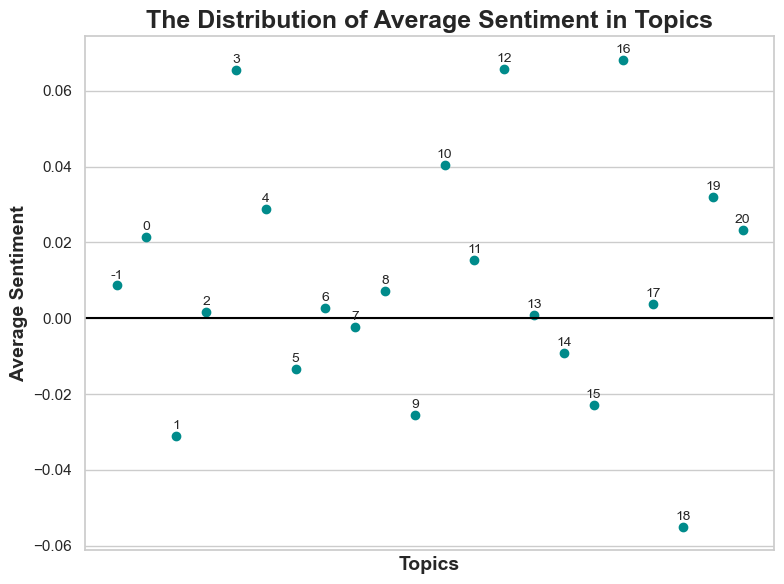

In [149]:
# Plotting the sentiment score per topic
fig, ax = plt.subplots(figsize=(8, 6))

plt.scatter(data=df_topic_sentiment, y='Average sentiment', x='Topic Number', color="darkcyan")

df_topic_sentiment["Topic Number"] = df_topic_sentiment["Topic Number"].astype(int)

# Add value for 'Topic Number' next to each dot
for i in range(len(df_topic_sentiment)):
    ax.annotate(df_topic_sentiment['Topic Number'].iloc[i],
                (df_topic_sentiment['Topic Number'].iloc[i], df_topic_sentiment['Average sentiment'].iloc[i]),
                textcoords="offset points",
                xytext=(0, 5),
                ha='center',
                fontsize=10)

plt.xlabel('Topics', fontsize=14, fontweight='bold')
plt.ylabel('Average Sentiment', fontsize=14, fontweight='bold')
plt.title('The Distribution of Average Sentiment in Topics', fontsize=18, fontweight='bold')


plt.xticks([])
ax.axhline(0, color='black', linewidth=1.5)

plt.tight_layout()
plt.show()

In [123]:
df_topic_sentiment[['Topic Number', 'Average sentiment']]

,Topic Number,Average sentiment
0,-1.0,0.008653
1,0.0,0.021495
2,10.0,0.040490
3,11.0,0.015320
4,12.0,0.065669
5,13.0,0.000753
6,14.0,-0.009155
7,15.0,-0.022801
8,16.0,0.068236
9,17.0,0.003760


## Validation of the results

In [131]:
import random
df_sentiment_score = pd.read_csv(cwd+"/data/Comment_sentiment_score.csv")
df_manual_sentiment = pd.read_csv(cwd+"/data/Manual_sentiment_analysis.csv")

In [132]:
#Taking a random sample of 100 comments
random_sample = df_sentiment_score.sample(n=100, random_state=9)

#Only keeping the columns we need
random_sample = random_sample[['Comment Text', 'Sentiment']]

#Saving the sample
random_sample.to_csv(cwd+"/data/Random_sample.csv", index=False)


In [133]:
#Reduce the length to only get the first 100 rows
df_manual_sentiment = df_manual_sentiment[:100]
df_manual_sentiment.head()

,Comment Text,Manual Sentiment 1,Manual Sentiment 2,Manual Coding Evaluation,Manual Sentiment 3,Sentiment
0,So are project managers safe? I guess I'm only...,0,-,False,0,-0.051740
1,did the same and got a 100 with 5mins of work,+,+,True,NaN,0.130596
2,This. I've been banned from at least 2-3 subs ...,-,-,True,NaN,-0.047542
3,I agree with you largely. There is a bit too m...,-,-,True,NaN,0.064295
4,AI: We should increase our workers salary beca...,0,-,False,0,0.406878


In [134]:
#Adding a column based on the final manually coded sentiment
df_manual_sentiment['Final Manual'] = 0
for index1, row1 in enumerate(df_manual_sentiment['Manual Coding Evaluation']):
    if row1 == True:
        df_manual_sentiment['Final Manual'][index1] = df_manual_sentiment['Manual Sentiment 1'][index1]
    else:
        df_manual_sentiment['Final Manual'][index1] = df_manual_sentiment['Manual Sentiment 3'][index1] 

df_manual_sentiment.head()

C:\Users\noort\AppData\Local\Temp\ipykernel_3364\403843743.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_manual_sentiment['Final Manual'][index1] = df_manual_sentiment['Manual Sentiment 3'][index1]


,Comment Text,Manual Sentiment 1,Manual Sentiment 2,Manual Coding Evaluation,Manual Sentiment 3,Sentiment,Final Manual
0,So are project managers safe? I guess I'm only...,0,-,False,0,-0.051740,0
1,did the same and got a 100 with 5mins of work,+,+,True,NaN,0.130596,+
2,This. I've been banned from at least 2-3 subs ...,-,-,True,NaN,-0.047542,-
3,I agree with you largely. There is a bit too m...,-,-,True,NaN,0.064295,-
4,AI: We should increase our workers salary beca...,0,-,False,0,0.406878,0


In [135]:
#Adding a column to label the sentiment score given by the model
df_manual_sentiment['Final Model'] = 0
for index2, row2 in enumerate(df_manual_sentiment['Sentiment']):
    if row2 < -0.25:
        df_manual_sentiment['Final Model'][index2] = '-'
    elif row2 > 0.25:
        df_manual_sentiment['Final Model'][index2] = '+'
    else:
        df_manual_sentiment['Final Model'][index2] = '0'

df_manual_sentiment.head()

C:\Users\noort\AppData\Local\Temp\ipykernel_3364\11531820.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_manual_sentiment['Final Model'][index2] = '0'


,Comment Text,Manual Sentiment 1,Manual Sentiment 2,Manual Coding Evaluation,Manual Sentiment 3,Sentiment,Final Manual,Final Model
0,So are project managers safe? I guess I'm only...,0,-,False,0,-0.051740,0,0
1,did the same and got a 100 with 5mins of work,+,+,True,NaN,0.130596,+,0
2,This. I've been banned from at least 2-3 subs ...,-,-,True,NaN,-0.047542,-,0
3,I agree with you largely. There is a bit too m...,-,-,True,NaN,0.064295,-,0
4,AI: We should increase our workers salary beca...,0,-,False,0,0.406878,0,+


In [136]:
#Calculating the accuracy of the model
df_manual_sentiment['Correct'] = 0
for index3, row3 in enumerate(df_manual_sentiment['Final Manual']):
    if row3 == df_manual_sentiment['Final Model'][index3]:
        df_manual_sentiment['Correct'][index3] = 1
    else:
        df_manual_sentiment['Correct'][index3] = 0 



C:\Users\noort\AppData\Local\Temp\ipykernel_3364\834443096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_manual_sentiment['Correct'][index3] = 1
C:\Users\noort\AppData\Local\Temp\ipykernel_3364\834443096.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_manual_sentiment['Correct'][index3] = 0


In [139]:
#Percentage of agreement between manual coding 1 and 2
print(f"Percentage of agreement between manual coding 1 and 2: {(df_manual_sentiment['Manual Sentiment 1']== df_manual_sentiment['Manual Sentiment 2']).sum() / len(df_manual_sentiment)}")
#The accuracy of the model
print(f"Accuracy of the model: {df_manual_sentiment['Correct'].sum() / len(df_manual_sentiment)}")

Percentage of agreement between manual coding 1 and 2: 0.63
Accuracy of the model: 0.67


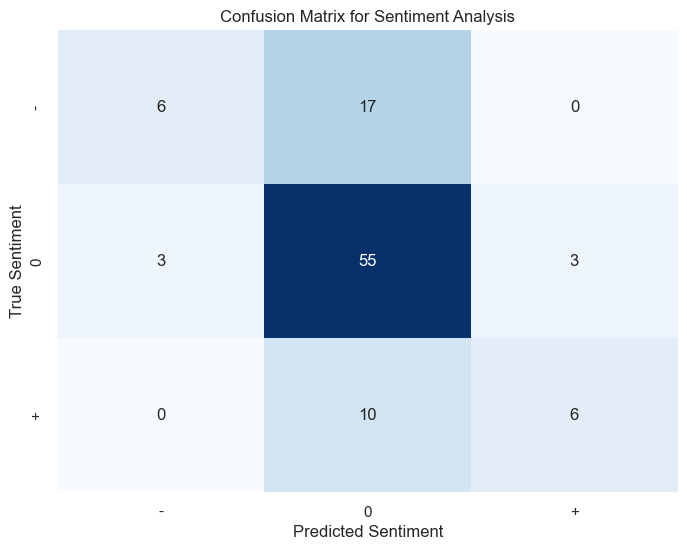

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels =['-', '0', '+']
cm = confusion_matrix(df_manual_sentiment['Final Manual'], df_manual_sentiment['Final Model'], labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()


In [97]:
#Adding the final manual sentiment
for index, row1 in enumerate(df_manual_sentiment):
    if df_manual_sentiment['Manual Sentiment 1'][index] == df_manual_sentiment['Manual Sentiment 2'][index]:
        df_manual_sentiment.loc[index, 'Final Manual Sentiment'] = df_manual_sentiment['Manual Sentiment 1'][index]
    else:
        df_manual_sentiment.loc[index, 'Final Manual Sentiment'] = df_manual_sentiment['Manual Sentiment 3'][index]

df_manual_sentiment['Model Label'] = 0
#Labelling the sentiment score
for row2 in df_manual_sentiment['Sentiment']:
    if row2 < -0.25:
        df_manual_sentiment['Model Label'] = '-' #Negative
    elif row2 > 0.25:
        df_manual_sentiment['Model Label'] = '+' #Positive
    else:
        df_manual_sentiment['Model Label'] = '0' #Nautral


,Comment Text,Manual Sentiment 1,Manual Sentiment 2,Manual Coding Evaluation,Manual Sentiment 3,Sentiment,Final Manual Sentiment,Model Label
0,So are project managers safe? I guess I'm only...,0,-,False,0,-0.051740,0,0
1,did the same and got a 100 with 5mins of work,+,+,True,NaN,0.130596,+,0
2,This. I've been banned from at least 2-3 subs ...,-,-,True,NaN,-0.047542,-,0
3,I agree with you largely. There is a bit too m...,-,-,True,NaN,0.064295,-,0
4,AI: We should increase our workers salary beca...,0,-,False,0,0.406878,0,0
5,It may comfort you to know that OpenAI researc...,0,+,False,0,0.092436,0,0
6,"That's a turing reply, come on",0,-,False,0,0.002263,NaN,0
7,"I find this particularly ironic. "" how could ...",0,-,False,0,0.023511,NaN,0
8,,0,0,True,NaN,0.011793,NaN,0
9,... because it learned from humans? All it doe...,0,-,False,0,-0.095206,NaN,0
